In [223]:
! pip install pybaseball

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [224]:
import pybaseball
import numpy as np # library for numerical computations (vectors, matrices, tensors)
import numpy.testing as np_testing # for tests
import matplotlib.pyplot as plt # library providing tools for plotting data
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans # library for K-Means clustering
from sklearn import metrics # library providing score functions, performance metrics and pairwise metrics and distance computations
from sklearn.metrics import mean_squared_error, confusion_matrix as calculate_confusion_matrix
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D # library for 3D axes object
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [225]:
#types = pybaseball.statcast(start_dt="2022-05-07", end_dt="2022-11-05").columns

In [226]:
#print(types)

# what the data looks like

In [227]:
#pybaseball.cache.enable()
data = pybaseball.statcast(start_dt="2022-05-07", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


100%|██████████| 183/183 [00:24<00:00,  7.32it/s]


In [228]:
data_small = data.loc[data['game_type'] == 'R', ['pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z']].reset_index(False)

In [229]:
data_small = data_small.drop(columns=["index"])

In [230]:
data_small = data_small.dropna()

In [231]:
data_small

,pitch_type,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z
0,CH,80.8,1771,213,-1.34,0.8
1,FF,97.7,2434,189,-0.17,1.58
2,CH,84.9,1856,212,-1.22,0.83
3,FF,97.2,2258,192,-0.13,1.74
4,SL,86.2,2348,127,0.63,0.0
...,...,...,...,...,...,...
595854,FF,94.2,2034,151,0.32,1.04
595855,SL,88.1,2259,167,-0.47,0.33
595856,FF,92.3,1920,158,0.03,0.92
595857,FF,93.6,1933,153,0.27,1.08


In [232]:
def count_data_points_per_label(dataframe):
    # Use the 'groupby' function to group by the 'Label' column and count the occurrences
    label_counts = dataframe['pitch_type'].value_counts().reset_index()
    label_counts.columns = ['pitch_type', 'Count']
    
    # Sort the result by counts in descending order
    label_counts = label_counts.sort_values(by='Count', ascending=False)
    
    # Convert the result to a list of dictionaries
    label_counts_list = label_counts.to_dict('records')
    
    return label_counts_list

label_counts_list = count_data_points_per_label(data_small)
print(label_counts_list)

[{'pitch_type': 'FF', 'Count': 196170}, {'pitch_type': 'SL', 'Count': 104795}, {'pitch_type': 'SI', 'Count': 92786}, {'pitch_type': 'CH', 'Count': 66466}, {'pitch_type': 'CU', 'Count': 46505}, {'pitch_type': 'FC', 'Count': 43246}, {'pitch_type': 'ST', 'Count': 18002}, {'pitch_type': 'KC', 'Count': 12992}, {'pitch_type': 'FS', 'Count': 9161}, {'pitch_type': 'SV', 'Count': 2065}, {'pitch_type': 'FA', 'Count': 1118}, {'pitch_type': 'EP', 'Count': 506}, {'pitch_type': 'CS', 'Count': 62}, {'pitch_type': 'PO', 'Count': 35}, {'pitch_type': 'KN', 'Count': 19}]


In [233]:
def remove_rows_by_label(dataframe, label_to_remove):
    # Use boolean indexing to filter rows based on the label to remove
    filtered_df = dataframe[dataframe['pitch_type'] != label_to_remove]
    return filtered_df

remove_types = ['KN', 'PO', 'CS', 'EP', 'FA', 'SV', 'FS']
filtered_data_small = data_small
for label in remove_types:
    filtered_data_small = remove_rows_by_label(filtered_data_small, label)
print(count_data_points_per_label(filtered_data_small))

[{'pitch_type': 'FF', 'Count': 196170}, {'pitch_type': 'SL', 'Count': 104795}, {'pitch_type': 'SI', 'Count': 92786}, {'pitch_type': 'CH', 'Count': 66466}, {'pitch_type': 'CU', 'Count': 46505}, {'pitch_type': 'FC', 'Count': 43246}, {'pitch_type': 'ST', 'Count': 18002}, {'pitch_type': 'KC', 'Count': 12992}]


In [234]:
def balance_dataframe(df, label_column):
    # Determine the minimum number of datapoints among labels
    min_count = df[label_column].value_counts().min()
    
    # Create an empty DataFrame to store balanced data
    balanced_df = pd.DataFrame(columns=df.columns)
    
    # Undersample each label to match the minimum count
    for label in df[label_column].unique():
        label_data = df[df[label_column] == label]
        label_data = label_data.sample(min_count, random_state=42)
        balanced_df = pd.concat([balanced_df, label_data], ignore_index=True)
    
    return balanced_df

balanced_data = balance_dataframe(filtered_data_small, 'pitch_type')
print(count_data_points_per_label(balanced_data))

[{'pitch_type': 'CH', 'Count': 12992}, {'pitch_type': 'FF', 'Count': 12992}, {'pitch_type': 'SL', 'Count': 12992}, {'pitch_type': 'ST', 'Count': 12992}, {'pitch_type': 'CU', 'Count': 12992}, {'pitch_type': 'SI', 'Count': 12992}, {'pitch_type': 'KC', 'Count': 12992}, {'pitch_type': 'FC', 'Count': 12992}]


In [235]:

def z_score_normalize_dataframe(df, label_column, value_column):
    # Group the DataFrame by the label column
    grouped = df.groupby(label_column)
    
    # Create an empty DataFrame to store the z-score normalized data
    normalized_df = pd.DataFrame(columns=[label_column, value_column])
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Iterate through each group, normalize the values, and concatenate to the result
    for label, group in grouped:
        group[value_column] = scaler.fit_transform(group[[value_column]])
        normalized_df = pd.concat([normalized_df, group], ignore_index=True)
    
    return normalized_df
features = ['pfx_z', 'pfx_x', 'spin_axis', 'release_spin_rate','release_speed']
#features = ['pfx_x', 'spin_axis', 'release_spin_rate','release_speed']
normalized_data = balanced_data
for value in features:
    normalized_data = z_score_normalize_dataframe(normalized_data, 'pitch_type', value)
print(normalized_data)

       pitch_type release_speed release_spin_rate spin_axis     pfx_x  \
0              CH      0.134963         -0.280901  0.530367 -0.464673   
1              CH     -0.010955          0.870027  0.513315 -0.670695   
2              CH     -1.382588         -1.332896  0.428055 -0.773705   
3              CH     -0.331976          0.170896  0.734992 -0.808042   
4              CH      0.922923          0.220363  1.195397 -0.747952   
...           ...           ...               ...       ...       ...   
103931         ST     -0.725252         -2.175252  1.950297 -1.534262   
103932         ST      1.502899          1.681001 -0.372774  0.225529   
103933         ST      0.166009          0.557044  1.809504 -1.382402   
103934         ST      0.420655         -1.535678  -0.47334   0.35059   
103935         ST      0.166009          1.981976  1.779335 -1.918379   

           pfx_z  
0      -0.657824  
1       0.664356  
2       0.766062  
3       0.842342  
4      -1.776591  
...      

In [236]:
validation_size = 0.30  # 30% in total for validation (15%) and testing (15%)
testing_size = 0.70  # 70% for testing

In [237]:
validation_data, training_data = train_test_split(normalized_data, test_size=testing_size, random_state=40)

In [238]:
validation_data, testing_data =  train_test_split(validation_data, test_size=0.5, random_state=40)

In [239]:
y_val = validation_data["pitch_type"]
X_val = validation_data.drop(columns=["pitch_type"])
y = training_data["pitch_type"]
X = training_data.drop(columns=["pitch_type"])
y_test = testing_data["pitch_type"]
X_test = testing_data.drop(columns=["pitch_type"])

In [240]:
X_val1 = X_val.to_numpy()
y_val1 = y_val.to_numpy()
X1 = X.to_numpy()
y1 = y.to_numpy()
X_test1 = X_test.to_numpy()
y_test1 = y_test.to_numpy()

In [241]:
alltypes = []
n = 0
for i in y1:
    if (i not in alltypes):
        #print(i)
        if(i ==None):
            print(n)
        alltypes.append(i)
    n = n +1 
print(alltypes)
print(len(alltypes))

['SI', 'FF', 'CH', 'CU', 'SL', 'ST', 'KC', 'FC']
8


In [242]:
#k_values = [1, 3, 5, 7, 9, 11]

# Iterate over K values and evaluate the model
#for k in k_values:
#    knn = KNeighborsClassifier(n_neighbors=k)
#    scores = cross_val_score(knn, X1, y1, cv=5, scoring='accuracy')
#    mean_score = scores.mean()
#    print(f"K={k}: Mean Accuracy = {mean_score}")

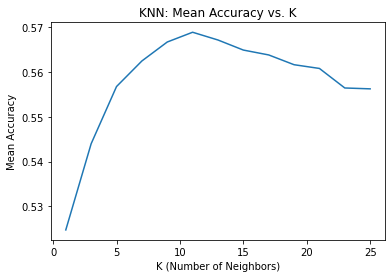

In [243]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_val1, y_val1, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())

plt.plot(k_values, mean_scores)
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Accuracy')
plt.title('KNN: Mean Accuracy vs. K')
plt.show()

Elbow test shows would indicate k = 5, k = 7 or k = 9 would be good choices

Accuracy: 0.6216805644644002


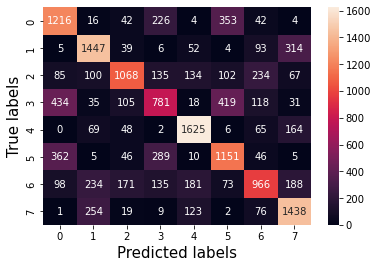

In [244]:
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')
neigh.fit(X1,y1)
y_test_pred = neigh.predict(X_test1)
acc = accuracy_score(y_test_pred,y_test1)
confmat = confusion_matrix(y_test1, y_test_pred)

print("Accuracy:", acc)
# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

Accuracy: 0.6286080821039127


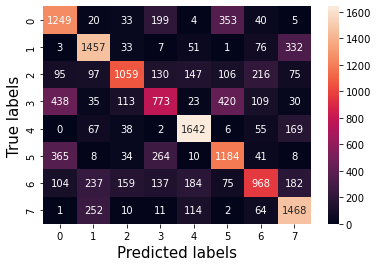

In [245]:
neigh = KNeighborsClassifier(n_neighbors=7, weights='distance')
neigh.fit(X1,y1)
y_test_pred = neigh.predict(X_test1)
acc = accuracy_score(y_test_pred,y_test1)
confmat = confusion_matrix(y_test1, y_test_pred)

print("Accuracy:", acc)
# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

Accuracy: 0.6333547145606158


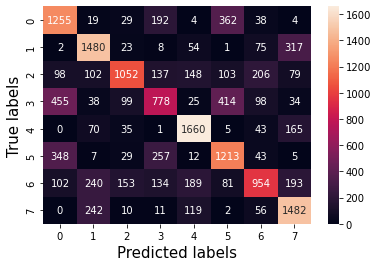

In [246]:
neigh = KNeighborsClassifier(n_neighbors=9, weights='distance')
neigh.fit(X1,y1)
y_test_pred = neigh.predict(X_test1)
acc = accuracy_score(y_test_pred,y_test1)
confmat = confusion_matrix(y_test1, y_test_pred)

print("Accuracy:", acc)
# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

Accuracy: 0.6354073123797306


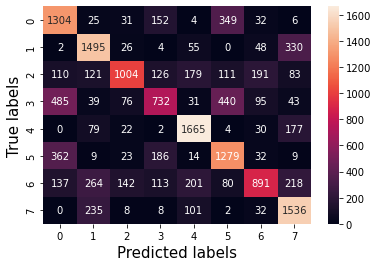

In [247]:
neigh = KNeighborsClassifier(n_neighbors=25, weights='distance')
neigh.fit(X1,y1)
y_test_pred = neigh.predict(X_test1)
acc = accuracy_score(y_test_pred,y_test1)
confmat = confusion_matrix(y_test1, y_test_pred)

print("Accuracy:", acc)
# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()